# **Implementing OAuth 2.0 using Xero**

![picture](https://developer.xero.com/static/images/documentation/authflow.svg)

In [1]:
import json
import requests
import base64
#create a new app
#copy and paste your client id and client secret below
# Read this document to learn the process: https://developer.xero.com/documentation/oauth2/auth-flow

In [3]:
client_id = input("enter client_id : ")
client_secret =input("client_secret : ")

enter client_id : 373EC817108D49C1B29999499B2AAC98
client_secret : xqrC1tfkd4myWYM3zbxNx780oVAFrkmcMAAoJzosocxQ6U9f


In [4]:
redirect_url = 'https://developer.xero.com/'
scope = 'offline_access accounting.transactions'
b64_id_secret = base64.b64encode(bytes(client_id + ':' + client_secret, 'utf-8')).decode('utf-8')
#click this link : https://developer.xero.com/documentation/oauth2/scopes to know more about scopes

def XeroFirstAuth():
    # 1. Send a user to authorize your app
    auth_url = ('''https://login.xero.com/identity/connect/authorize?''' +
                '''response_type=code''' +
                '''&client_id=''' + client_id +
                '''&redirect_uri=''' + redirect_url +
                '''&scope=''' + scope +
                '''&state=123''')
    print("Open this URL:\n")
    print(auth_url)

    # 2. Users are redirected back to you with a code
    auth_res_url = input('What is the response URL? ')
    start_number = auth_res_url.find('code=') + len('code=')
    end_number = auth_res_url.find('&scope')
    auth_code = auth_res_url[start_number:end_number]
    print("authentication code :")
    print(auth_code)
    print('\n')
    
    # 3. Exchange the code
    exchange_code_url = 'https://identity.xero.com/connect/token'
    response = requests.post(exchange_code_url, 
                            headers = {
                                'Authorization': 'Basic ' + b64_id_secret
                            },
                            data = {
                                'grant_type': 'authorization_code',
                                'code': auth_code,
                                'redirect_uri': redirect_url
                            })
    json_response = response.json()
    print(json_response)
    print('\n')
    
    # 4. Receive your tokens
    return [json_response['access_token'], json_response['refresh_token']]


In [5]:
# First Time running the script
old_tokens = XeroFirstAuth()

Open this URL:

https://login.xero.com/identity/connect/authorize?response_type=code&client_id=373EC817108D49C1B29999499B2AAC98&redirect_uri=https://developer.xero.com/&scope=offline_access accounting.transactions&state=123
What is the response URL? https://developer.xero.com/?code=48b9df4ba9aa2382d04171ca04e27bed9d492bffd3b682440e24c477cb353c20&scope=accounting.transactions&state=123
authentication code :
48b9df4ba9aa2382d04171ca04e27bed9d492bffd3b682440e24c477cb353c20


{'access_token': 'eyJhbGciOiJSUzI1NiIsImtpZCI6IjFDQUY4RTY2NzcyRDZEQzAyOEQ2NzI2RkQwMjYxNTgxNTcwRUZDMTkiLCJ0eXAiOiJKV1QiLCJ4NXQiOiJISy1PWm5jdGJjQW8xbkp2MENZVmdWY09fQmsifQ.eyJuYmYiOjE2MDc2ODQ3MTksImV4cCI6MTYwNzY4NjUxOSwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS54ZXJvLmNvbSIsImF1ZCI6Imh0dHBzOi8vaWRlbnRpdHkueGVyby5jb20vcmVzb3VyY2VzIiwiY2xpZW50X2lkIjoiMzczRUM4MTcxMDhENDlDMUIyOTk5OTQ5OUIyQUFDOTgiLCJzdWIiOiJiMzRkNmE4MzAzYzY1OGJjYjRhNzE4ZTUxNzQ5MzM1ZSIsImF1dGhfdGltZSI6MTYwNzY4MzE1MiwieGVyb191c2VyaWQiOiIzNTJiYWUxMi1mZjc3LTQxZjQtOTM1Zi04Yz

In [6]:
# 5. Check the full set of tenants you've been authorized to access
def XeroTenants(access_token):
    connections_url = 'https://api.xero.com/connections'
    response = requests.get(connections_url,
                           headers = {
                               'Authorization': 'Bearer ' + access_token,
                               'Content-Type': 'application/json'
                           })
    json_response = response.json()
    print(json_response)
    
    for tenants in json_response:
        json_dict = tenants
    return json_dict['tenantId']

In [7]:
XeroTenants(old_tokens[0])

[{'id': 'a98ea6e7-91c5-4d82-a147-026f8ca3acc5', 'authEventId': '6c0081d3-72c1-41c2-ae89-4a729b32b93d', 'tenantId': '1a4382f0-f825-4ec9-b097-6fa33995375e', 'tenantType': 'ORGANISATION', 'tenantName': 'Darko', 'createdDateUtc': '2020-12-10T13:44:48.2478490', 'updatedDateUtc': '2020-12-10T13:44:48.2502800'}, {'id': '2406793e-84ec-4a94-a719-1eb4a5e0f3cc', 'authEventId': 'b8231f6a-a963-4565-8f56-1c5c92f2f0d9', 'tenantId': '5cec262b-1eaf-4265-8424-f103701ef432', 'tenantType': 'ORGANISATION', 'tenantName': 'Demo Company (Global)', 'createdDateUtc': '2020-12-10T13:24:01.0465440', 'updatedDateUtc': '2020-12-10T13:24:01.0487380'}]


'5cec262b-1eaf-4265-8424-f103701ef432'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 6.1 Refreshing access tokens
def XeroRefreshToken(refresh_token):
    token_refresh_url = 'https://identity.xero.com/connect/token'
    response = requests.post(token_refresh_url,
                            headers = {
                                'Authorization' : 'Basic ' + b64_id_secret,
                                'Content-Type': 'application/x-www-form-urlencoded'
                            },
                            data = {
                                'grant_type' : 'refresh_token',
                                'refresh_token' : refresh_token
                            })
    json_response = response.json()
    print(json_response)
    
    new_refresh_token = json_response['refresh_token']
    rt_file = open('/content/drive/My Drive/data/refresh_token.txt', 'w')
    rt_file.write(new_refresh_token)
    rt_file.close()
    
    return [json_response['access_token'], json_response['refresh_token']]

In [10]:
XeroRefreshToken(old_tokens[1])

{'id_token': 'eyJhbGciOiJSUzI1NiIsImtpZCI6IjFDQUY4RTY2NzcyRDZEQzAyOEQ2NzI2RkQwMjYxNTgxNTcwRUZDMTkiLCJ0eXAiOiJKV1QiLCJ4NXQiOiJISy1PWm5jdGJjQW8xbkp2MENZVmdWY09fQmsifQ.eyJuYmYiOjE2MDc2ODQ5MTgsImV4cCI6MTYwNzY4NTIxOCwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS54ZXJvLmNvbSIsImF1ZCI6IjM3M0VDODE3MTA4RDQ5QzFCMjk5OTk0OTlCMkFBQzk4IiwiaWF0IjoxNjA3Njg0OTE4LCJhdF9oYXNoIjoidnZJQXlGTXhhZjkxUjNWSFNpTXVMQSIsInN1YiI6ImIzNGQ2YTgzMDNjNjU4YmNiNGE3MThlNTE3NDkzMzVlIiwiYXV0aF90aW1lIjoxNjA3NjgzMTUyLCJ4ZXJvX3VzZXJpZCI6IjM1MmJhZTEyLWZmNzctNDFmNC05MzVmLThjNzU0N2VhY2E5OSIsImdsb2JhbF9zZXNzaW9uX2lkIjoiYzljMDM2ZjJmODlhNGE4Y2I4ZTk0YTQzNmVlMzkxYzEiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJoYXJpc2h2MTk5OUBnbWFpbC5jb20iLCJlbWFpbCI6ImhhcmlzaHYxOTk5QGdtYWlsLmNvbSIsImdpdmVuX25hbWUiOiJIYXJpc2giLCJmYW1pbHlfbmFtZSI6IlYifQ.bbYIFu-5RGmU_dDdVGZ35Jy8_WRhfyGqIIQkFxQ2UNxkal3Xb9FFCsMQKgbkdYypLMtBKTJAUoBE-V5FzX0mIg5tCamkOSS90oXqKMPunBe4T5kCpU6KQAjaKMldKGE57SWN-VG_7fV8Q1y5S_GQ4vtKFI7hzEn3QxS737yQJPDf6IO_vZEzXLVL95EgNWesKUwkokzK77FKcSmwxqMC9_K0Nm6nO3BhICVg0Fqv

['eyJhbGciOiJSUzI1NiIsImtpZCI6IjFDQUY4RTY2NzcyRDZEQzAyOEQ2NzI2RkQwMjYxNTgxNTcwRUZDMTkiLCJ0eXAiOiJKV1QiLCJ4NXQiOiJISy1PWm5jdGJjQW8xbkp2MENZVmdWY09fQmsifQ.eyJuYmYiOjE2MDc2ODQ5MTgsImV4cCI6MTYwNzY4NjcxOCwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS54ZXJvLmNvbSIsImF1ZCI6Imh0dHBzOi8vaWRlbnRpdHkueGVyby5jb20vcmVzb3VyY2VzIiwiY2xpZW50X2lkIjoiMzczRUM4MTcxMDhENDlDMUIyOTk5OTQ5OUIyQUFDOTgiLCJzdWIiOiJiMzRkNmE4MzAzYzY1OGJjYjRhNzE4ZTUxNzQ5MzM1ZSIsImF1dGhfdGltZSI6MTYwNzY4MzE1MiwieGVyb191c2VyaWQiOiIzNTJiYWUxMi1mZjc3LTQxZjQtOTM1Zi04Yzc1NDdlYWNhOTkiLCJnbG9iYWxfc2Vzc2lvbl9pZCI6ImM5YzAzNmYyZjg5YTRhOGNiOGU5NGE0MzZlZTM5MWMxIiwianRpIjoiYTBmYjNjZTFmOTExOGUxNGRlZTI3YWIzYzU0MDk1NGUiLCJhdXRoZW50aWNhdGlvbl9ldmVudF9pZCI6IjhjN2QyN2JkLTgyYTMtNDhjYi1hYjQ3LTQwMTIwMGNkZDY5YyIsInNjb3BlIjpbImVtYWlsIiwicHJvZmlsZSIsIm9wZW5pZCIsImFjY291bnRpbmcucmVwb3J0cy5yZWFkIiwiYWNjb3VudGluZy5hdHRhY2htZW50cy5yZWFkIiwicHJvamVjdHMiLCJhY2NvdW50aW5nLnNldHRpbmdzIiwiYWNjb3VudGluZy5zZXR0aW5ncy5yZWFkIiwiYWNjb3VudGluZy5hdHRhY2htZW50cyIsImFjY291bnRpbmcudHJhbnNhY3R

In [11]:
# 6.2 Call the API
def XeroRequests():
    old_refresh_token = open('/content/drive/My Drive/data/refresh_token.txt', 'r').read()
    new_tokens = XeroRefreshToken(old_refresh_token)
    xero_tenant_id = XeroTenants(new_tokens[0])
    print(xero_tenant_id)
    get_url = 'https://api.xero.com/api.xro/2.0/Invoices'
    response = requests.get(get_url,
                           headers = {
                               'Authorization': 'Bearer ' + new_tokens[0],
                               'Xero-tenant-id': xero_tenant_id,
                               'Accept': 'application/json'
                           })
    json_response = response.json()
    print(json_response)
    
    xero_output = open('/content/drive/My Drive/data/xero_output.txt', 'w')
    xero_output.write(response.text)
    xero_output.close()

In [12]:
# Every other time
XeroRequests()

{'id_token': 'eyJhbGciOiJSUzI1NiIsImtpZCI6IjFDQUY4RTY2NzcyRDZEQzAyOEQ2NzI2RkQwMjYxNTgxNTcwRUZDMTkiLCJ0eXAiOiJKV1QiLCJ4NXQiOiJISy1PWm5jdGJjQW8xbkp2MENZVmdWY09fQmsifQ.eyJuYmYiOjE2MDc2ODQ5MzIsImV4cCI6MTYwNzY4NTIzMiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS54ZXJvLmNvbSIsImF1ZCI6IjM3M0VDODE3MTA4RDQ5QzFCMjk5OTk0OTlCMkFBQzk4IiwiaWF0IjoxNjA3Njg0OTMyLCJhdF9oYXNoIjoib0FtMDdUSF9BZ3BXVk5SQVBSTFk0QSIsInN1YiI6ImIzNGQ2YTgzMDNjNjU4YmNiNGE3MThlNTE3NDkzMzVlIiwiYXV0aF90aW1lIjoxNjA3NjgzMTUyLCJ4ZXJvX3VzZXJpZCI6IjM1MmJhZTEyLWZmNzctNDFmNC05MzVmLThjNzU0N2VhY2E5OSIsImdsb2JhbF9zZXNzaW9uX2lkIjoiYzljMDM2ZjJmODlhNGE4Y2I4ZTk0YTQzNmVlMzkxYzEiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJoYXJpc2h2MTk5OUBnbWFpbC5jb20iLCJlbWFpbCI6ImhhcmlzaHYxOTk5QGdtYWlsLmNvbSIsImdpdmVuX25hbWUiOiJIYXJpc2giLCJmYW1pbHlfbmFtZSI6IlYifQ.EEJm-zEWZwcvpYSi-H5lUMCYWS8XjB91q82okcLo6HR4MQcpPBvLG_WLDju-j0cFhCFOS94VDYDVKomXYIakpaOeZc-sI3dZ5FLh0zkqidL5DJo8CE2csFwR6P13XCP6dgWpEBlisu9nxxZ42GzxtLunzlAIKcBNjfF41Wnle1d_mCiJvRUZRjibf7qZ9Nsz9-F01YDd5PzCRzcOZa6g8hjj1ZxMmFC2PKtIafsS

In [14]:
def export_csv():
    invoices = open(r'/content/drive/My Drive/data/xero_output.txt', 'r').read()
    json_invoice = json.loads(invoices)
    analysis = open(r'/content/drive/My Drive/data/analysis.csv', 'w')
    analysis.write('InvoiceNumber' + ',' + 'Reference' + ',' + 'Type' + ',' + 'Total')
    analysis.write('\n')
    for invoices in json_invoice['Invoices']:
        analysis.write(invoices['InvoiceNumber'] + ',' + invoices['Reference'] + ',' + invoices['Type'] + ',' + str(invoices['Total']))
        analysis.write('\n')
    analysis.close()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
def chart_data():
    df = pd.read_csv(r'/content/drive/My Drive/data/analysis.csv')
    pvt = df[ ['InvoiceNumber','Reference','Type','Total'] ]
    # .groupby('Type').sum()
    print(pvt)
    
    pvt.plot.bar(stacked=True)
    plt.show()

In [22]:
export_csv()

   InvoiceNumber        Reference    Type    Total
0       INV-0027        Ref MK815  ACCREC   396.00
1             AP              NaN  ACCPAY    59.54
2             AP              NaN  ACCPAY    31.39
3       INV-0010         Training  ACCREC   541.25
4       INV-0005  Monthly Support  ACCREC   541.25
..           ...              ...     ...      ...
63          RENT              NaN  ACCPAY  1181.25
64           Rpt              NaN  ACCPAY    46.82
65           Rpt              NaN  ACCPAY   135.85
66      INV-0030  Monthly support  ACCREC   550.00
67      INV-0029  Monthly support  ACCREC   550.00

[68 rows x 4 columns]


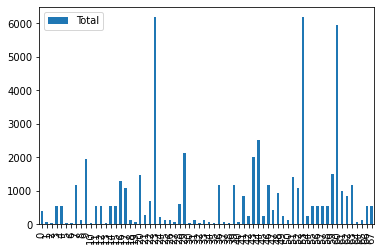

<Figure size 432x288 with 0 Axes>

In [23]:
chart_data()

In [18]:
from google.colab import files
files.download('/content/drive/My Drive/data/xero_output.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
files.download('/content/drive/My Drive/data/analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>